In [23]:
import numpy as np
import pandas as pd
import ast
from scipy import stats
from scipy.signal import welch
from scipy.integrate import simpson
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
data_path = '../Data/Processed/sub01_binned_raw.csv'
eeg_data_raw = pd.read_csv(data_path)

eeg_task_path = '../Data/Processed/sub01_binned_task_raw.csv'
eeg_task_raw = pd.read_csv(eeg_task_path)

data_path = '../Data/Processed/sub01_binned.csv'
eeg_data = pd.read_csv(data_path)

eeg_task_path = '../Data/Processed/sub01_binned_task.csv'
eeg_task = pd.read_csv(eeg_task_path)

In [15]:
def extract_features_from_trial(trial_data, sfreq=256, max_length=2048):
    """Extract features from a single trial for all electrodes."""
    features = {}

    # Preprocess each electrode's data
    for electrode, signal_str in trial_data.items():
        # Convert string representation of list to an actual list
        signal = ast.literal_eval(signal_str)
        
        # Truncate or pad to max_length
        if len(signal) > max_length:
            signal = signal[:max_length]
        else:
            signal = signal + [0] * (max_length - len(signal))
        
        signal = np.array(signal)  # Convert to NumPy array
        
        # Extract statistical features
        features[f'{electrode}_mean'] = np.mean(signal)
        features[f'{electrode}_std'] = np.std(signal)
        features[f'{electrode}_variance'] = np.var(signal)
        features[f'{electrode}_skewness'] = stats.skew(signal)
        features[f'{electrode}_kurtosis'] = stats.kurtosis(signal)
        features[f'{electrode}_rms'] = np.sqrt(np.mean(signal ** 2))
        features[f'{electrode}_entropy'] = -np.sum(signal * np.log2(np.abs(signal) + 1e-10))
        features[f'{electrode}_peak_to_peak'] = np.ptp(signal)
        features[f'{electrode}_energy'] = np.sum(signal ** 2)
        features[f'{electrode}_zero_crossings'] = np.sum(np.diff(np.sign(signal)) != 0)
        features[f'{electrode}_mean_absolute_value'] = np.mean(np.abs(signal))

        # Frequency-domain features using Welch's method
        freqs, psd = welch(signal, sfreq)
        total_power = simpson(psd, x=freqs)
        
        # Define EEG frequency bands
        delta_band = (0.5, 4)
        theta_band = (4, 8)
        alpha_band = (8, 12)
        beta_band = (12, 30)
        gamma_band = (30, 50)
        
        def band_power(freqs, psd, band):
            band_freqs = np.logical_and(freqs >= band[0], freqs <= band[1])
            return simpson(psd[band_freqs], x=freqs[band_freqs] if np.any(band_freqs) else 0)

        # Calculate power in each frequency band
        features[f'{electrode}_delta_power'] = band_power(freqs, psd, delta_band)
        features[f'{electrode}_theta_power'] = band_power(freqs, psd, theta_band)
        features[f'{electrode}_alpha_power'] = band_power(freqs, psd, alpha_band)
        features[f'{electrode}_beta_power'] = band_power(freqs, psd, beta_band)
        features[f'{electrode}_gamma_power'] = band_power(freqs, psd, gamma_band)
        features[f'{electrode}_total_power'] = total_power

        # Calculate relative power
        for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
            features[f'{electrode}_{band}_relative_power'] = features[f'{electrode}_{band}_power'] / total_power if total_power > 0 else 0

    return features

In [16]:
def extract_features_for_all_trials(eeg_data, sfreq=256, max_length=2048):
    """Extract features from all trials in the DataFrame."""
    all_features = []
    labels = eeg_data['label_type'].values
    
    # Drop non-electrode columns like 'label' and 'label_type'
    eeg_data_filtered = eeg_data.drop(columns=['label', 'label_type'])

    # Iterate through each trial
    for idx, row in tqdm.tqdm(eeg_data_filtered.iterrows(), desc='Extracting Features'):
        trial_data = row.to_dict()
        features = extract_features_from_trial(trial_data, sfreq=sfreq, max_length=max_length)
        features['label_type'] = labels[idx]  # Add the label to the features
        all_features.append(features)
    
    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    return features_df

In [17]:
features_df = extract_features_for_all_trials(eeg_data, sfreq=256, max_length=2048)
print("Extracted features shape:", features_df.shape)
print(features_df.head())

Extracting Features: 0it [00:00, ?it/s]

Extracting Features: 319it [02:43,  1.95it/s]


Extracted features shape: (319, 1409)
    F3_mean    F3_std  F3_variance  F3_skewness  F3_kurtosis    F3_rms  \
0 -0.022183  0.723163     0.522964     0.195949    -0.065646  0.723503   
1 -0.048845  1.095038     1.199108     0.383110     0.912246  1.096127   
2  0.137669  0.751424     0.564639    -0.034453    -0.434508  0.763931   
3 -0.095704  0.967195     0.935466     0.507013     0.228473  0.971919   
4  0.064079  0.939491     0.882643     0.082815    -0.224032  0.941674   

   F3_entropy  F3_peak_to_peak    F3_energy  F3_zero_crossings  ...  \
0  -87.942722         4.159038  1072.038447                101  ...   
1 -162.395732         7.178368  2460.660178                 76  ...   
2  -35.339627         4.088842  1195.194967                101  ...   
3 -246.290459         5.847367  1934.593432                 96  ...   
4 -110.436851         5.191948  1816.063067                 82  ...   

   CP4_alpha_power  CP4_beta_power  CP4_gamma_power  CP4_total_power  \
0         0.008064

In [20]:
features_df.to_csv('../Data/Features/sub01_features_processed.csv', index=False)

In [21]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    plt.show()

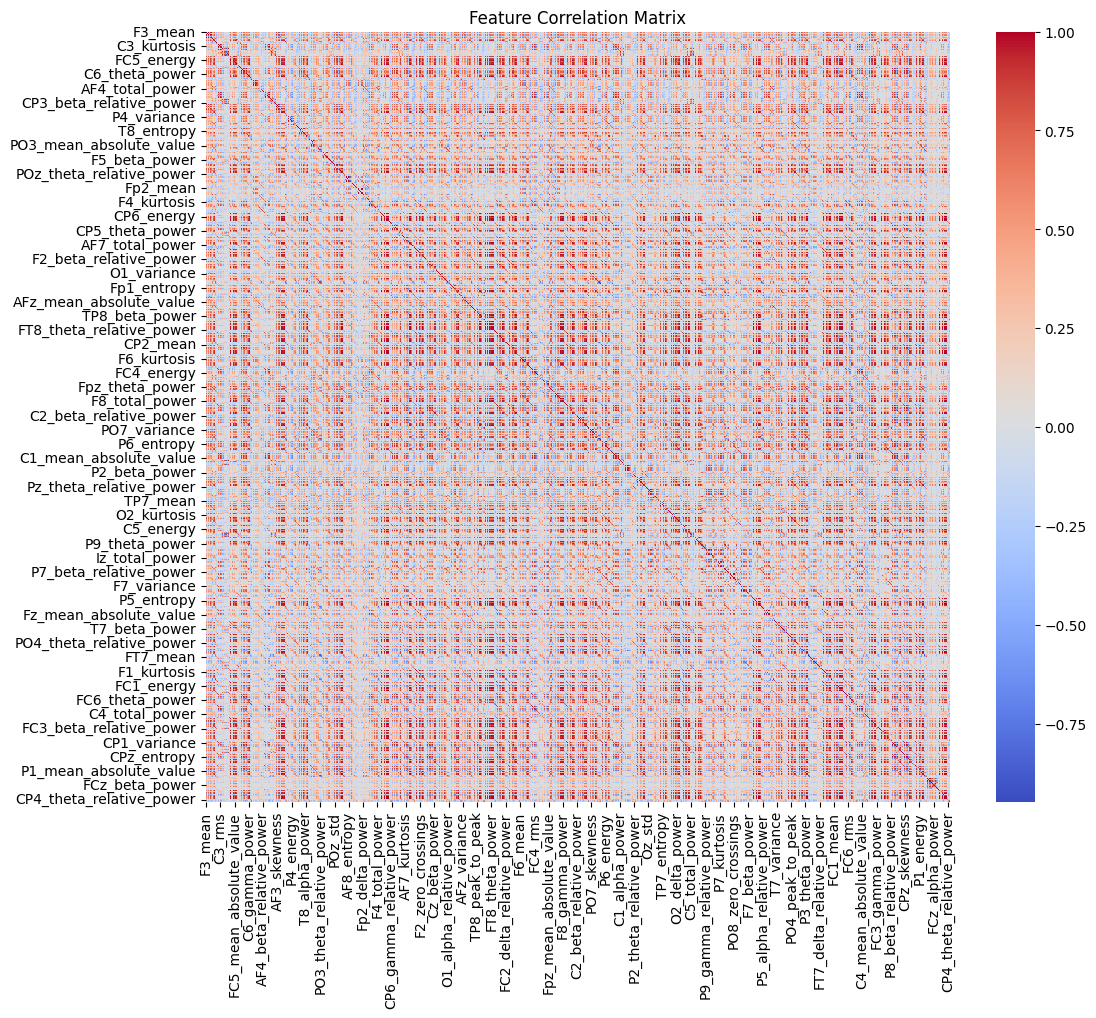

In [24]:
plot_correlation_matrix(features_df.drop(columns=['label_type']))